# Odos pigmentinių darinių klasifikavimas

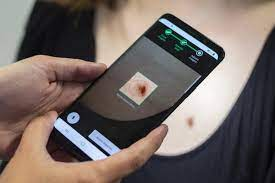

## Duomenys

Duomenų rinkinį sudaro **10 015** dermatoskopinių vaizdų ir apima visas svarbias pigmentinių pažeidimų kategorijas. Duomenų šaltinis - **Medical University of Vienna**.
Duomenys išleisti mašininio mokymosi tikslais ir yra viešai prieinami **ISIC archyve**. ISIC (angl. - *The International Skin Imaging Collaboration*) -  Tarptautinė odos vaizdavimo bendruomenė. ISIC yra akademinės bendruomenės ir pramonės partnerystė, skirta palengvinti skaitmeninių odos vaizdų taikymą ir padėti sumažinti mirtingumą nuo melanomos.

Pigmentinių pažeidimų kategorijos:

- aktininė keratozė ir intraepitelinė karcinoma / Boweno liga (AKIEC),
- **bazinių ląstelių karcinoma (BCC)**,
- gerybiniai į keratozę panašūs pažeidimai (seborėjinė keratozė, plokščioji keratozė) (BKL),
- dermatofibroma (DF),
- **melanoma (MEL)**,
- melanocytiniai apgamai (NV)
- kraujagyslių pažeidimai (angioma, angiokeratoma, kt.) (VASC).

## Aplinkos paruošimas

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential


import time
import warnings
warnings.filterwarnings("ignore")

In [14]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.2, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 10.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

### Vaizdų nuskaitymas

In [15]:
fpath=r'../input/ham1000-segmentation-and-classification/images/ISIC_0024306.jpg'
img=plt.imread(fpath)
print (img.shape)
plt.imshow(img)

### Kategorijų kodų nuskaitymas iš *csv* failo 

In [16]:
df = pd.read_csv(r'../input/ham1000-segmentation-and-classification/GroundTruth.csv')
print (df.head())
print (len(df))
print (df.columns)

In [17]:
df['image']=df['image'].apply(lambda x: x+ '.jpg')
print (df.head())

In [18]:
labels = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
label_list = []
for i in range (len(df)):
    row = list(df.iloc[i])
    del row[0]
    index = np.argmax(row)
    label = labels[index]
    label_list.append(label)
df['label'] = label_list
df = df.drop(labels, axis = 1)
print (df.head())

## Duomenų rinkinio skaidymas į *train*, *test* and *valid*

In [19]:
train_df, test_valid_df = train_test_split(df,            train_size=0.9, shuffle=True, random_state=42)
valid_df, test_df       = train_test_split(test_valid_df, train_size=0.5, shuffle=True, random_state=42)

print('train_df length: ', len(train_df))  
print('test_df length:  ', len(test_df))  
print('valid_df length: ', len(valid_df))  
print('')
print (train_df['label'].value_counts())

### *train* rinkinio balansavimas

In [20]:
print ('original number of classes: ', len(df['label'].unique()))     
size=300 
samples=[]
group=df.groupby('label')
for label in df['label'].unique():
    lgroup=group.get_group(label)
    count=int(lgroup['label'].value_counts())    
    if count>=size:
        sample=lgroup.sample(size, axis=0)        
    else:        
        sample=lgroup.sample(frac=1, axis=0)
    samples.append(sample) 
train_df=pd.concat(samples, axis=0).reset_index(drop=True)
print (len(train_df))
print ('final number of classes: ', len(train_df['label'].unique()))       
print (train_df['label'].value_counts())  

## Generatorių *train*, *test* ir *valid* sukurimas:

Keras ImageDataGenerator with flow_from_dataframe takes the dataframe and the path to a directory + generates batches. The generated batches contain augmented/normalized data.

Returns: a ImageFileIterator yielding tuples of (x, y) where x is a numpy array containing a batch of images with shape (batch_size, *target_size, channels) and y is a numpy array of corresponding labels.

Generate batches of tensor image data with real-time data augmentation.

In [21]:
sdir=r'../input/ham1000-segmentation-and-classification/images' # main directory where data is stored
height=299  
width=299  
channels=3  
batch_size=40  
img_shape=(height, width, channels)
img_size=(height, width)
# code below determines test generator batch size and steps so that test_batch_size X test_steps = number of test samples
# ensures that for predictions you go through the test set exactly once
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

In [22]:
gen=ImageDataGenerator() # no scaling of pixels is need for efficientnet
train_ds=gen.flow_from_dataframe(dataframe = train_df, 
                                  directory = sdir, 
                                  x_col = 'image', 
                                  y_col = 'label', 
                                  target_size = img_size, 
                                  class_mode = 'categorical',
                                  color_mode = 'rgb', 
                                  shuffle = True, 
                                  batch_size = batch_size)
test_ds=gen.flow_from_dataframe(dataframe = test_df, 
                                 directory = sdir, 
                                 x_col ='image', 
                                 y_col ='label', 
                                 target_size = img_size, 
                                 class_mode = 'categorical',
                                 color_mode ='rgb', 
                                 shuffle = False, 
                                 batch_size = test_batch_size)
val_ds=gen.flow_from_dataframe(dataframe = valid_df, 
                                  directory = sdir, 
                                  x_col = 'image', 
                                  y_col='label', 
                                  target_size = img_size, 
                                  class_mode = 'categorical',
                                  color_mode = 'rgb', 
                                  shuffle = True, 
                                  batch_size = batch_size)
classes = list(train_ds.class_indices.keys())
class_count = len(classes)
train_steps = int(len(train_ds.labels)/batch_size)

In [23]:
def show_image_samples(gen):
    test_dict=test_ds.class_indices
    print(test_dict)
    classes=list(test_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(10, 10))
    length=len(labels)
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255 # scale images between 0 and 1 becaue no preprocessing scaling was done for efficientnet
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_ds)

## Modelis.EfficientNetB1 

In [24]:
base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)        
output=Dense(7, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='categorical_crossentropy', metrics=['accuracy']) 

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_monitor = EarlyStopping(patience=7, restore_best_weights=True)
total_epochs = 19

In [32]:
%%time
history = model.fit(train_ds, epochs=total_epochs, verbose=True, 
                    validation_data=val_ds, callbacks = [early_stopping_monitor])

In [27]:
plot_history(history)

In [28]:
latest = 'model.ckpt'
model.save_weights(latest)

In [29]:
# Create a new model instance
# model = create_model()
# Load the previously saved weights
model.load_weights(latest)

# Evaluation and predictiond
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [30]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions_prob = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions_prob < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(11, 9))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'pred:{labels[predictions[i]]},p={predictions_prob[i]:0.2f}\nact:{labels[label_batch[i]]}')
  plt.axis("off")

In [ ]:
model.save("my_model.h5")